# Preprocessing:
### Remove 50Hz signal and slow drift resulting from measurement process

Mounted at /content/drive


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
from scipy.signal import lfilter, butter
import os
import time

In [5]:
#Read data and annotations
DF = pd.read_csv("Data/104.csv", dtype=int, sep='\s*,\s*',delimiter=',')
DF_annotations = pd.read_csv("Data/104annotations.txt", header=0, sep=r"\s+")

#Extra column "DummyCol" (contains only NaN) is present to deal with column names in original file that contain a white space
DF_annotations.columns = ["Time", "Sample #", "Type", "Sub", "Chan" , "Num", "Aux", "DummyCol"]

#Delete extra column
del DF_annotations["DummyCol"]

In [6]:
#DF.head()
#DF_annotations.head()

In [7]:
#Filter signal using Butterworth Bandpass filter at lowcut=0.4Hz, highcut=45Hz

# Adapted code from: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

#Sampling freq, high-/low- cut freqs (Hz)
fs = 360.0
lowcut = 0.4
highcut = 45.0

filtered = butter_bandpass_filter(DF.iloc[:,1], lowcut, highcut, fs, order=3)
filtered2 = butter_bandpass_filter(DF.iloc[:,2], lowcut, highcut, fs, order=3)

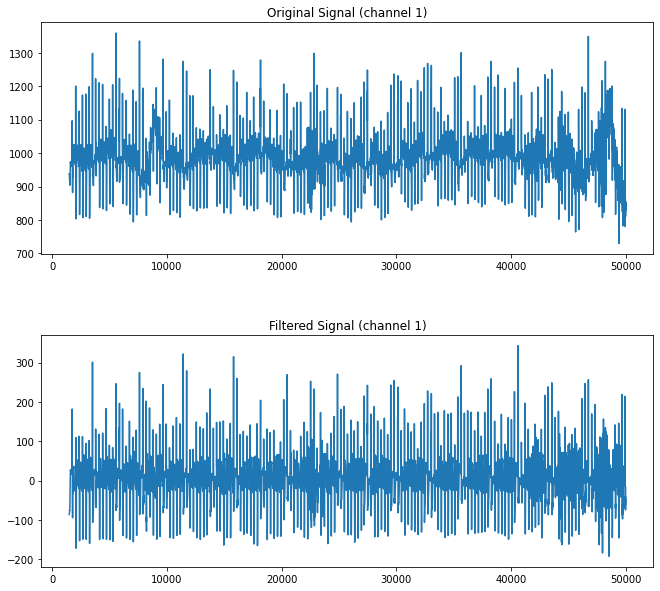

In [8]:
#Plot original and filtered data for channel 1
Rows = np.arange(1500,50000,5)

#Unfiltered signal
Y = DF.iloc[Rows,1]

plt.figure(3,figsize=[10,9])

plt.subplot(212)
plt.plot(Rows, filtered[Rows])
plt.title('Filtered Signal (channel 1)')    

plt.subplot(211)
plt.plot(Rows, Y)
plt.title('Original Signal (channel 1)')    


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

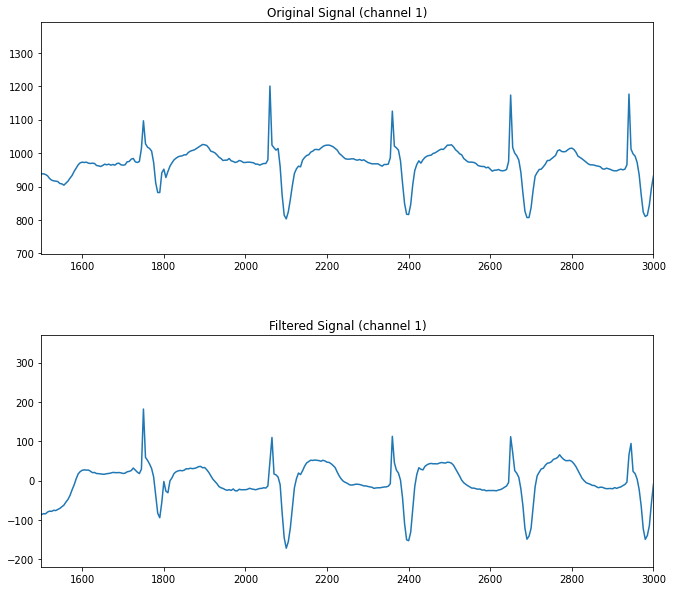

In [9]:
#Plot original and filtered data for channel 1
Rows = np.arange(1500,50000,5)

#Unfiltered signal
Y = DF.iloc[Rows,1]

plt.figure(3,figsize=[10,9])

plt.subplot(212)
plt.plot(Rows, filtered[Rows])
plt.title('Filtered Signal (channel 1)')
plt.xlim(1500, 3000)    

plt.subplot(211)
plt.plot(Rows, Y)
plt.title('Original Signal (channel 1)')
plt.xlim(1500, 3000)    


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

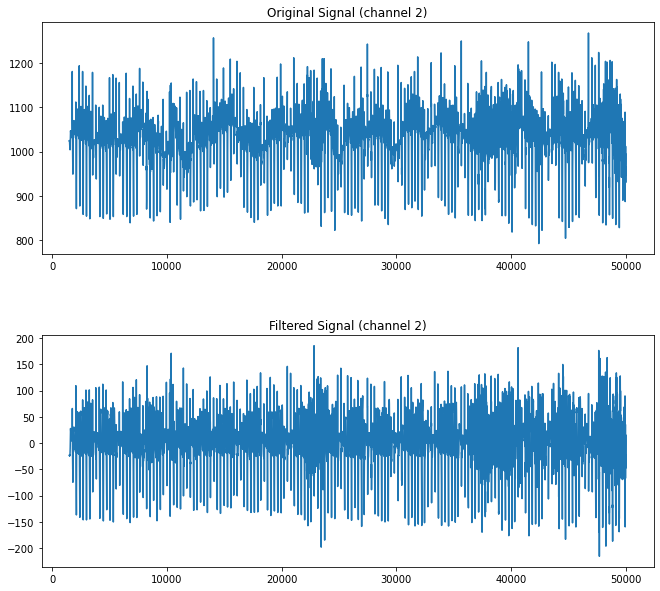

In [10]:
#Plot original and filtered data for channel 2

Rows = np.arange(1500,50000,5)

#Unfiltered signal
Y = DF.iloc[Rows,2]

plt.figure(3,figsize=[10,9])

plt.subplot(212)
plt.plot(Rows, filtered2[Rows])
plt.title('Filtered Signal (channel 2)')    

plt.subplot(211)
plt.plot(Rows, Y)
plt.title('Original Signal (channel 2)')    


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

## Load training data

In [11]:
#function that returns 1 if annotation corresponds to a beat otherwise returns 0
def is_beat(x):
    if (x=='N' or x=='L' or x=='R' or x=='B' or x=='A' or x=='a' or x=='J' or x=='S' or x=='V' or x=='r' or x=='F' or x=='e' or x=='j'
         or x=='n' or x=='E' or x=='/' or x=='f' or x=='Q' or x=='?'):
        return 1
    else:
        return 0
    
#function that returns appropriate dimension index based on beat annotation for one hot encodings 
def beat_to_dimension(x):
    if x=='N':  #N  Normal beat
        return 0
    if x=='L':  #L  Left bundle branch block beat
        return 1
    if x=='R':  #R  Right bundle branch block beat
        return 2
    if x=='B':  #B  Bundle branch block beat (unspecified)
        return 3
    if x=='A':  #A  Atrial premature beat
        return 4 
    if x=='a':  #a  Aberrated atrial premature beat
        return 5
    if x=='J':  #J  Nodal (junctional) premature beat
        return 6
    if x=='S':  #S  Supraventricular premature or ectopic beat (atrial or nodal)
        return 7
    if x=='V':  #V  Premature ventricular contraction
        return 8
    if x=='r':  #r  R-on-T premature ventricular contraction
        return 9
    if x=='F':  #F  Fusion of ventricular and normal beat
        return 10
    if x=='e':  #e  Atrial escape beat
        return 11
    if x=='j':  #j  Nodal (junctional) escape beat
        return 12
    if x=='n':  #n  Supraventricular escape beat (atrial or nodal)
        return 13
    if x=='E':  #E  Ventricular escape beat
        return 14
    if x=='/':  #/  Paced beat
        return 15
    if x=='f':  #f  Fusion of paced and normal beat
        return 16
    if x=='Q':  #Q  Unclassifiable beat
        return 17
    if x=='?':  #?  Beat not classified during learning
        return 18

In [12]:
#Time slot for training: 7.50 minutes (note that the time slot window is different for each patient).

Start_min = 15  # time-window start
End_min = 22.5  #time-window end



#Using the fact that there are 360 samples per second
Index_start = int(360*Start_min*60)   # samples/sec * starting time (mins) * 60sec/min
Index_finish = int(360*End_min*60)    # samples/sec * end time (mins) * 60sec/min
print(Index_start)
print(Index_finish)

#Training data
#channel 1
x = filtered[Index_start:Index_finish]
#channel 2
x2 = filtered2[Index_start:Index_finish]

print(x.shape,x2.shape)
print(x)
print(x2)
print(len(x))
print(len(x2))

# one hot encoding for targets (19 different beat types)
ytarget = np.zeros((len(x),19))
    
for i in range(len(DF_annotations["Type"])):   #Loop over annotations
    if (Index_start<DF_annotations.iloc[i]["Sample #"]<Index_finish):  # Annotations inside time-window of interest
        if is_beat(DF_annotations.iloc[i]["Type"]):                     # If annotation is a beat:
            index = beat_to_dimension(DF_annotations.iloc[i]["Type"])     # dimension for one-hot encoding of beat
            index2 = DF_annotations.iloc[i]["Sample #"]-Index_start       # index for time, normalized to start from index 0
            ytarget[index2][index]=1
            #print(index2)
            #print(index)


324000
486000
(162000,) (162000,)
[-17.76831147 -17.9647357  -17.22818315 ...  22.15337878  25.56179178
  28.54123751]
[ -2.59061282  -1.53551783  -0.30346185 ... -58.70624337 -45.06269563
 -33.25633001]
162000
162000


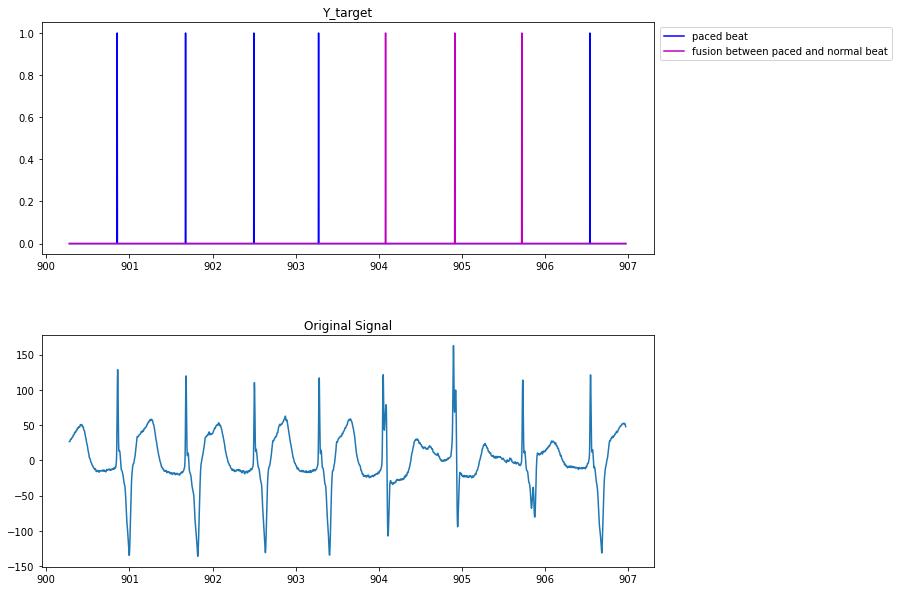

In [13]:
Time = np.arange(15*60, 22.5*60, 7.5*60/len(x)) # x-axis in seconds
TIME = np.arange(100,2510,1)                    # sample points of interest

plt.figure(4,figsize=[10,9])

plt.subplot(212)
plt.plot(Time[TIME], x2[TIME])
plt.title('Original Signal')    

plt.subplot(211)
plt.plot(Time[TIME], ytarget[TIME,15], color='b', label="paced beat")
plt.plot(Time[TIME], ytarget[TIME,16], color='m', label="fusion between paced and normal beat")
plt.title('Y_target')
plt.legend(loc='upper center', bbox_to_anchor=(1.2,1))



plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,wspace=0.65)
plt.show()

In [14]:
#RNN part

#possible beat annotations
df = pd.DataFrame(ytarget, columns=['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?'])
df['x'] = x
df['x2'] = x2
df.head()

#splits the data into a training part (80%) and a evaluation part (20%)
train_size = int(df.shape[0] * 0.8)
train_df = df[:train_size]
val_df = df[train_size:]
train_data = train_df[['x','x2']].to_numpy()
train_labels = train_df[df.columns[:2]].to_numpy()
val_data = val_df[['x','x2']].to_numpy()
val_labels = val_df[df.columns[:2]].to_numpy()

training_set_shape = train_data.shape

259200
259200
(129600, 2)


In [22]:
#RNN model
model = keras.models.Sequential()
model.add(keras.Input(shape=(129600, 2))) # input with sequence length 129600 and size 2
model.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
model.add(layers.Dense(19)) #because there are 19 possible annotations

# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#the optimizer is the keras adam optimizer using gradient descent, with a learning rate of 0.001
optimize = keras.optimizers.Adam(lr=0.001)


model.compile(loss=loss, optimizer=optimize, metrics=["accuracy"])

# training
batch_size = 64
epochs = 5

model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=2)

# evauluation
model.evaluate(val_data, val_labels, batch_size=batch_size, verbose=2)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


ValueError: ignored